In [2]:
import healpy as hp
import numpy as np
from turn import turn
from rot import rot
from shift_SW import shift_SW
import astropy.units as u
import matplotlib.pyplot as plt


0.0 180.0 -180.0 180.0


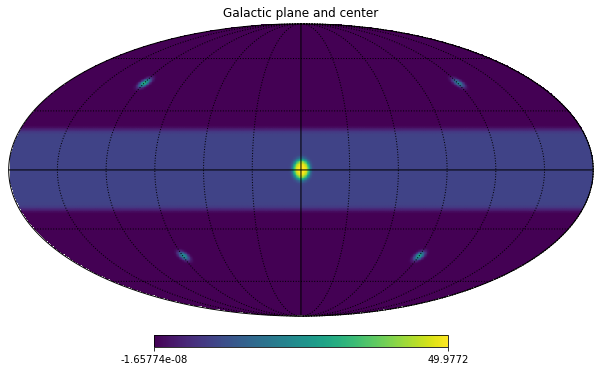

In [3]:
# Set empty array for pixel data
nside = 1024
m = np.zeros(hp.nside2npix(nside))

# Set galactic plane
gal_width = 20 * u.deg
galaxy_plane_pixels = hp.query_strip(nside, np.pi/2 - gal_width.to_value(u.radian),
                                     np.pi/2+ gal_width.to_value(u.radian))
m[galaxy_plane_pixels] = 10


# Set galatic centre
source_vector = hp.ang2vec(theta=np.pi/2, phi=0)
galactic_center_pixels = hp.query_disc(nside, source_vector, radius=(5*u.deg).to_value(u.radian))
m[galactic_center_pixels] = 50
#np.where(m ==50)

# Extra data
point_vec1 = hp.ang2vec(theta=np.pi/4, phi=2*np.pi/3)
point_vec2 = hp.ang2vec(theta=np.pi/4, phi=-2*np.pi/3)
point_vec3 = hp.ang2vec(theta=3*np.pi/4, phi=np.pi/2)
point_vec4 = hp.ang2vec(theta=3*np.pi/4, phi=-np.pi/2)
point_vec1_pixels = hp.query_disc(nside, point_vec1, radius=(2*u.deg).to_value(u.radian))
point_vec2_pixels = hp.query_disc(nside, point_vec2, radius=(2*u.deg).to_value(u.radian))
point_vec3_pixels = hp.query_disc(nside, point_vec3, radius=(2*u.deg).to_value(u.radian))  
point_vec4_pixels = hp.query_disc(nside, point_vec4, radius=(2*u.deg).to_value(u.radian))
m[point_vec1_pixels] = 45
m[point_vec2_pixels] = 30
m[point_vec3_pixels] = 35
m[point_vec4_pixels] = 40   

# Smooth map
data = hp.smoothing(m, fwhm=(3*u.deg).to_value(u.radian))
hp.mollview(data, title='Galactic plane and center')
hp.graticule()

In [4]:
# Create custom rotator, sets input longitude and latitude as new center
longitude = 45 * u.deg
latitude = 45 * u.deg
rot_custom = hp.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)], inv = True)  # Apparently, more accurate to use opposite to centre and invert
rot_custom_back = hp.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)]) 
#rot_custom(0,0, lonlat=True)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


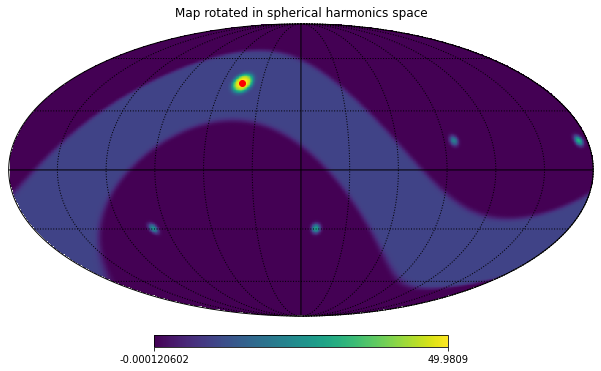

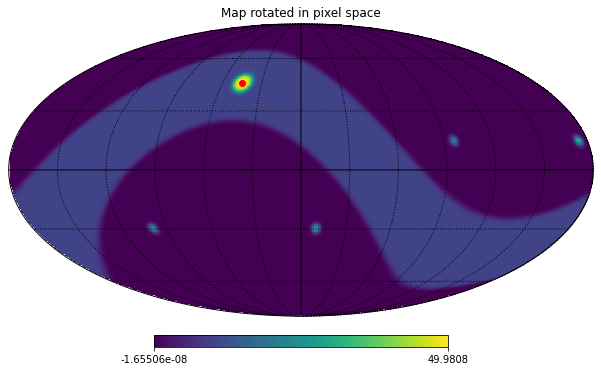

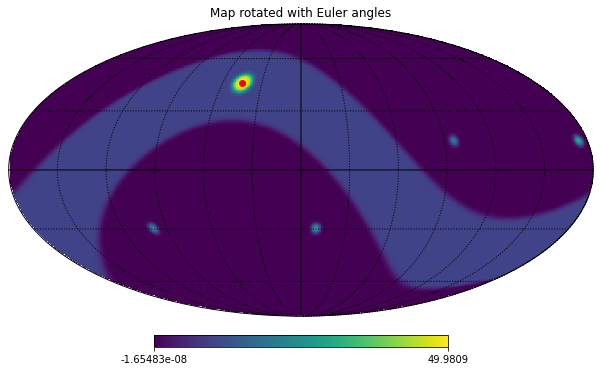

In [5]:
# Test .rotate_map_alms
data_rotated_alms = rot_custom.rotate_map_alms(data)
hp.mollview(data_rotated_alms, title="Map rotated in spherical harmonics space")
hp.projplot(45,45, 'ro', lonlat=True)
hp.graticule()
#print(test_rotated_alms)

# Test .rotate_map_pixel
data_rotated_pixel = rot_custom.rotate_map_pixel(data)
hp.mollview(data_rotated_pixel, title="Map rotated in pixel space")
hp.projplot(45,45, 'ro', lonlat=True)
hp.graticule()
#print(test_rotated_pixel)

# Test previous rotate function
data_rotated_euler = rot(nside,data,[45,45,0])
hp.mollview(data_rotated_euler, title="Map rotated with Euler angles")
hp.projplot(45,45, 'ro', lonlat=True)
hp.graticule()
#print(test_rotated_euler)

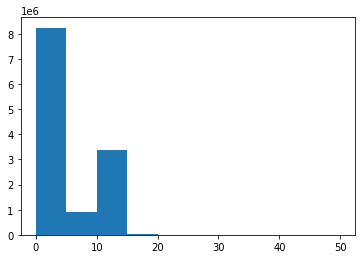

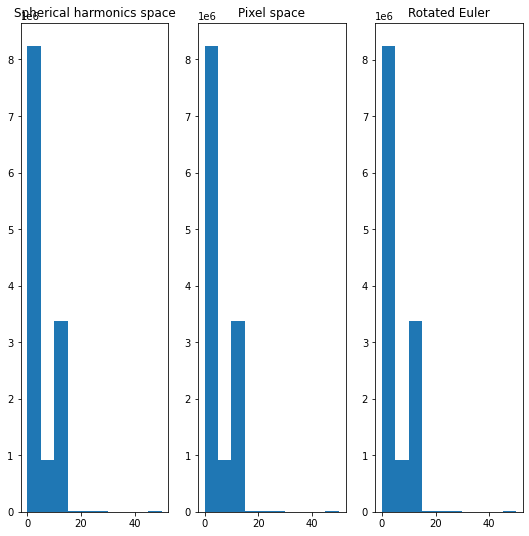

In [6]:
# Comparisons

plt.hist(data, bins = 10)
fig, axis = plt.subplots(1,3,figsize=(9,9))
axis[0].hist(data_rotated_alms, bins = 10)
axis[0].set_title("Spherical harmonics space")
axis[1].hist(data_rotated_pixel, bins = 10)
axis[1].set_title("Pixel space")
axis[2].hist(data_rotated_euler, bins = 10)
axis[2].set_title("Rotated Euler")
plt.show()

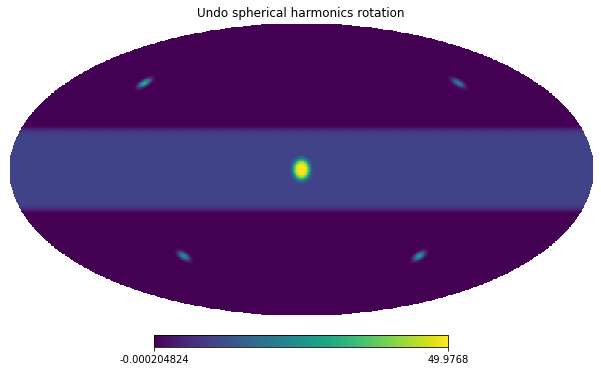

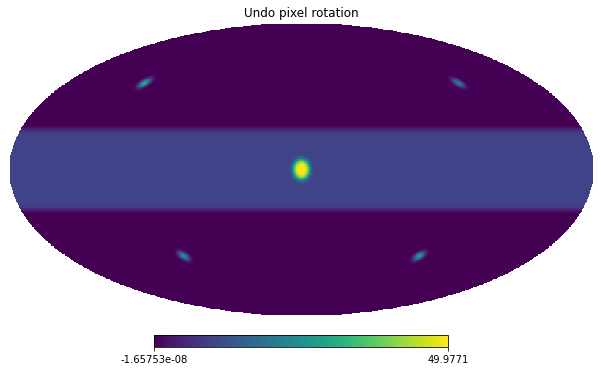

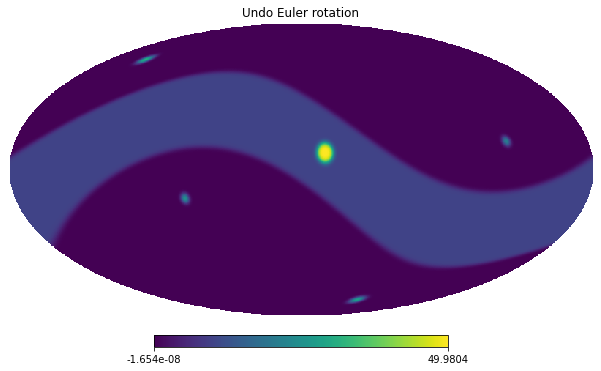

In [7]:
# Residuals
undo_alms = rot_custom_back.rotate_map_alms(data_rotated_alms)

undo_pixel = rot_custom_back.rotate_map_pixel(data_rotated_pixel)


undo_euler = rot(nside,data_rotated_euler,[-45,-45,0])  # Doesnt work for some reason
residual_euler = data - undo_euler

# Visualize rotating back to original
hp.mollview(undo_alms, title="Undo spherical harmonics rotation")
hp.mollview(undo_pixel, title="Undo pixel rotation")
hp.mollview(undo_euler, title="Undo Euler rotation")



(0.000539966195475472, 0.01589732440306335)

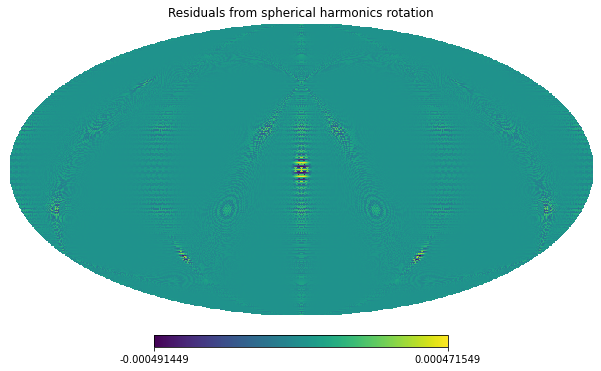

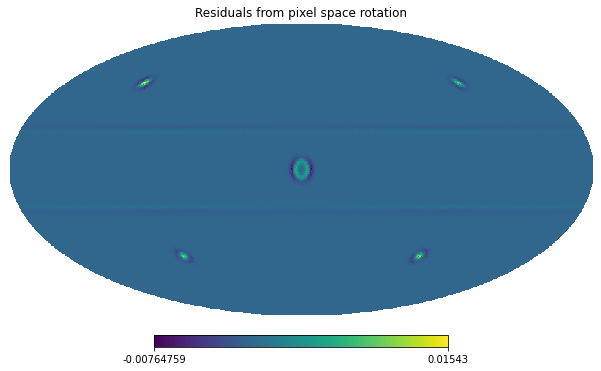

In [8]:
# Residuals 
residual_alms = data - undo_alms
residual_pixel = data - undo_pixel

# Visualize residuals
hp.mollview(residual_alms, title="Residuals from spherical harmonics rotation")
hp.mollview(residual_pixel, title="Residuals from pixel space rotation")

np.max(residual_alms), np.max(residual_pixel)